In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터 전처리 및 로딩
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# CIFAR-10 데이터셋 로딩 및 전처리
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# BasicBlock 정의
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.functional.relu(out)
        return out

# ResNet 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # 초기 컨볼루션 층
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # 레이어들 생성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # 마지막 평균 풀링 및 fully connected 층
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)
    # 레이어 생성 함수
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
     # forward 메소드
    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
# ResNet18 모델 생성 함수
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
# ResNet18 모델 인스턴스 생성 및 GPU로 이동
model = ResNet18()
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
# 손실 함수와 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# history를 저장하기 위한 리스트
history = {'epoch': [], 'loss': [], 'accuracy': [], 'test_loss': [], 'test_accuracy': []}

# 학습 루프
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # 훈련 데이터로 학습
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        # 원-핫 인코딩된 레이블 생성
        labels_onehot = nn.functional.one_hot(labels, num_classes=10).to(torch.float32)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels_onehot)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    # 검증 데이터로 정확도 계산
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels_onehot).item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = 100 * test_correct / test_total

    # history에 epoch와 정확도 추가
    history['epoch'].append(epoch + 1)
    history['loss'].append(running_loss / len(trainloader))  # 평균 손실 계산
    history['accuracy'].append(accuracy)  # 수정된 부분: 정확도를 history에 추가
    history['test_loss'].append(test_loss / len(testloader))  # 평균 검증 손실 계산
    history['test_accuracy'].append(test_accuracy)

    # history 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {history['loss'][-1]:.4f}, "
          f"Accuracy: {history['accuracy'][-1]:.2f}%, "
          f"TEST Loss: {history['test_loss'][-1]:.4f}, "
          f"TEST Accuracy: {history['test_accuracy'][-1]:.2f}%")


Epoch [1/15], Loss: 1.1620, Accuracy: 58.30%, TEST Loss: 0.9149, TEST Accuracy: 68.01%
Epoch [2/15], Loss: 0.7648, Accuracy: 73.15%, TEST Loss: 0.7709, TEST Accuracy: 73.50%
Epoch [3/15], Loss: 0.5692, Accuracy: 80.22%, TEST Loss: 0.6453, TEST Accuracy: 77.32%
Epoch [4/15], Loss: 0.4431, Accuracy: 84.60%, TEST Loss: 0.5011, TEST Accuracy: 82.95%
Epoch [5/15], Loss: 0.3411, Accuracy: 87.86%, TEST Loss: 0.5704, TEST Accuracy: 81.79%
Epoch [6/15], Loss: 0.2518, Accuracy: 91.14%, TEST Loss: 0.5602, TEST Accuracy: 82.40%
Epoch [7/15], Loss: 0.1792, Accuracy: 93.74%, TEST Loss: 0.6013, TEST Accuracy: 82.99%
Epoch [8/15], Loss: 0.1288, Accuracy: 95.41%, TEST Loss: 0.5806, TEST Accuracy: 84.21%
Epoch [9/15], Loss: 0.0988, Accuracy: 96.49%, TEST Loss: 0.6775, TEST Accuracy: 83.51%
Epoch [10/15], Loss: 0.0822, Accuracy: 97.13%, TEST Loss: 0.6442, TEST Accuracy: 84.26%
Epoch [11/15], Loss: 0.0677, Accuracy: 97.63%, TEST Loss: 0.7460, TEST Accuracy: 83.54%
Epoch [12/15], Loss: 0.0648, Accuracy: 97

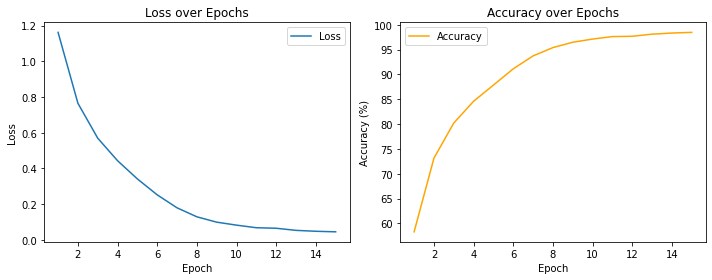

In [ ]:
    # epoch 마다 시각화
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['loss'], label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['accuracy'], label='Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
